Experiment based on article: https://openreview.net/forum?id=Pl7uHR-Oe6l
Kaggle notebook: https://www.kaggle.com/code/markbarreto/vehicle-speed-haversine-distance

In [ ]:
!pip install -q ultralytics
!pip install -q supervision==0.11.1

In [2]:
import os
import cv2
import json
import math
import time
import timeit
import numpy as np
import pandas as pd
import supervision as sv
from PIL import Image
from ultralytics import YOLO
from datetime import datetime

In [4]:
def get_videos(file):
    videos = []
    with open(file, 'r') as f:
        lines = json.load(f)
        for video in lines['points'].items():
            videos.append(video)
    return videos

def get_points(videos, address):
    for video in videos:
        if address == video[1]['address']:
            img_pts = np.array(video[1]['2dpts'], dtype = np.float32)
            wrld_pts = np.array(video[1]['pts'], dtype = np.float32)
            break
    return img_pts, wrld_pts

def homography_matrix(img_pts, wrld_pts):
    matrix, _ = cv2.findHomography(wrld_pts, img_pts)
    return matrix

def cvt_img2wrld_pts(hom_mtx, img_pt):
    img_pt = np.append(img_pt, 1)
    img_mtx = np.transpose(img_pt)
    img_mtx = img_mtx.reshape((3, 1))
    inv_hom_mtx = np.linalg.inv(hom_mtx)
    wrld_pt = np.dot(inv_hom_mtx, img_mtx)
    wrld_pt = wrld_pt / wrld_pt[2]
    return wrld_pt.flatten()[:2]

In [5]:
def haversine_distance(point1, point2):
    earth_radius = 6371.0
    point1 = np.radians(point1)
    point2 = np.radians(point2)
    dlat = point2[0] - point1[0]
    dlon = point2[1] - point1[1]
    a = math.sin(dlat/2)** 2
    b = math.cos(point2[0])*math.cos(point1[0])*math.sin(dlon/2)**2
    c = math.sqrt(a + b)
    distance = 2*earth_radius*math.asin(c)
    return distance

def ema_speed(speed1, speed2, alpha = 0.3):
    speed = alpha*speed1 + (1 - alpha)*speed2
    return speed2

def velocity(point1, point2, fps, f_count, ema = False, speed1 = 0):
    distance = haversine_distance(point1, point2)
    speed = (distance /  (f_count /  fps)) * 3600
    if ema:
        speed = ema_speed(speed1, speed)
    return distance, speed

def speed_from_img_pts(hom_mtx, point1, point2, fps, f_count, ema = False, speed1 = 0):
    point1 = cvt_img2wrld_pts(hom_mtx, point1)
    point2 = cvt_img2wrld_pts(hom_mtx, point2)
    distance, speed = velocity(point1, point2, fps, f_count, ema, speed1)
    return f'{(distance*1000):.2f}', speed

def create_file(file):
    if os.path.isfile(file):
        os.remove(file)
    with open(file, 'a+') as f:
        f.write('Id;Date;Begin;End;Distance(m);Speed(km/h)' + '\n')

In [6]:
def track(model, video, hom_mtx, save = False, show = False, output_video = ''):
    #count = 0
    vehicles_loc = {}
    vehicles_speed = {}
    classes = [2, 3, 5, 7]
    cap = cv2.VideoCapture(video)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if save:
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))
        video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))
    
    box_annotator = sv.BoxAnnotator(
        thickness = 2,
        text_thickness = 1,
        text_scale = 0.5
    )
    
    for frame_idx, result in enumerate(model.track(source=video, show = show, stream=True)):
        frame = result.orig_img
        detections = sv.Detections.from_yolov8(result)

        if result.boxes.id is not None:
            detections.tracker_id = result.boxes.id.cpu().numpy().astype(int)

        detections = detections[np.isin(detections.class_id, classes)]

        labels = []
        if detections.tracker_id is not None:
            for idx in range(len(detections.tracker_id)):
                tracker_id = detections.tracker_id[idx]
                class_id = detections.class_id[idx]
                confidence = detections.confidence[idx]

                if tracker_id not in vehicles_loc.keys():
                    cx = (detections.xyxy[idx][0] + detections.xyxy[idx][2]) / 2
                    cy = (detections.xyxy[idx][1] + detections.xyxy[idx][3]) / 2
                    vehicles_loc[tracker_id] = [[cx, cy], frame_idx, time.time()]
                    continue

                if tracker_id in vehicles_loc.keys():
                    frame_count = frame_idx - vehicles_loc[tracker_id][1]
                    if frame_count >= fps:
                        cx = (detections.xyxy[idx][0] + detections.xyxy[idx][2]) / 2
                        cy = (detections.xyxy[idx][1] + detections.xyxy[idx][3]) / 2
                        
                        if tracker_id in vehicles_speed.keys():
                            distance, speed = speed_from_img_pts(
                                hom_mtx, 
                                np.array(vehicles_loc[tracker_id][0], 
                                dtype = np.float32), np.array([cx, cy],
                                dtype = np.float32), 
                                fps, 
                                frame_count,
                                True,
                                vehicles_speed[tracker_id][0]
                            )
                            vehicles_speed[tracker_id][1] = speed
                            vehicles_speed[tracker_id][0] = speed
                        else:   
                            distance, speed = speed_from_img_pts(
                                hom_mtx, 
                                np.array(vehicles_loc[tracker_id][0], 
                                dtype = np.float32), np.array([cx, cy],
                                dtype = np.float32), 
                                fps, 
                                frame_count
                            )
                            vehicles_speed[tracker_id] = [speed, -1]
                            
                        formatted_time_begin = datetime.fromtimestamp(vehicles_loc[tracker_id][2])
                        formatted_time_end = datetime.fromtimestamp(time.time())
                        with open(file, 'a+') as f:
                            f.write(str(tracker_id) + ';' +
                                    str(formatted_time_begin.strftime('%d/%m/%Y')) + ';' +
                                    str(formatted_time_begin.strftime('%H:%M:%S')) + ';' +
                                    str(formatted_time_end.strftime('%H:%M:%S')) + ';' +
                                    distance + ';' +
                                    f'{speed:.2f}' + '\n'
                                   )
                        vehicles_loc[tracker_id] = [[cx, cy], frame_idx, time.time()] 
                
                if tracker_id in vehicles_speed.keys():
                    if vehicles_speed[tracker_id][1] >= 0:
                        labels.append(
                            f'#{tracker_id} {class_id} {model.model.names[class_id]} {vehicles_speed[tracker_id][1]:.2f}km/h {confidence:.2f}'
                        )
                    else:
                        labels.append(
                            f'#{tracker_id} {class_id} {model.model.names[class_id]} {vehicles_speed[tracker_id][0]:.2f}km/h {confidence:.2f}'
                        )
                    frame = box_annotator.annotate(scene = frame, detections = detections, labels = labels)
        
        if save:
            video_writer.write(frame)
        
        #if count >= 3000:
        #    break
        #count += 1
    if save:
        video_writer.release()

In [7]:
HOME = '/kaggle/input/evocamcal'
OUTPUT = '/kaggle/working'
video = os.path.join(HOME, 'seattle1.mp4')
output_video = os.path.join(OUTPUT, 'saida.mp4')
file = os.path.join(OUTPUT, 'vehicleSpeed.csv')

create_file(file)

model = YOLO("yolov8n.pt")

videos = get_videos(os.path.join(HOME, 'points.json'))
img_pts, wrld_pts = get_points(videos, '2nd Ave & Marion St')
matrix = homography_matrix(img_pts, wrld_pts)

track(model, video, matrix, save = True, show = False, output_video = output_video)

100%|██████████| 6.23M/6.23M [00:00<00:00, 72.0MB/s]
requirements: Ultralytics requirement "lapx>=0.5.2" not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for lapx: filename=lapx-0.5.2.post1-cp310-cp310-linux_x86_64.whl size=1475166 sha256=7cf7c828d1fdc47e59c628b685448760076fa09117d1199d5237345a68e8594f
  Stored in directory: /tmp/pip-ephem-wheel-cache-s5tgclf3/wheels/5c/6c/38/1953389265555a11c5abeae37f534a3568d986438a3132bf02
Successfully built lapx

requirements: 1 package upd

In [29]:
df = pd.read_csv(file, sep = ';')
df.head()

,Id,Date,Begin,End,Distance(m),Speed(km/h)
0,1,05/07/2023,18:24:39,18:24:42,6.68,24.03
1,2,05/07/2023,18:24:42,18:24:45,12.80,46.03
2,1,05/07/2023,18:24:42,18:24:45,3.39,12.18
3,3,05/07/2023,18:24:43,18:24:45,4.21,15.13
4,2,05/07/2023,18:24:45,18:24:48,13.98,50.27


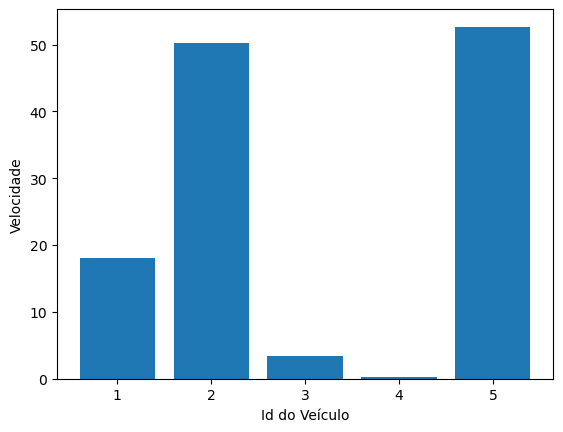

In [35]:
import matplotlib.pyplot as plt
dados = df.groupby('Id')['Speed(km/h)'].median()

plt.bar(dados.index, dados.values)
plt.xlabel('Id do Veículo')
plt.ylabel('Velocidade')
plt.show()

In [37]:
df['Speed(km/h)'].mean()

21.810000000000006